In [1]:
#The only thing to include in the paper/presentation from this code is the bar graph

import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
#import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

import random
random.seed(1000)

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#sns.set(rc={'figure.figsize':(11.7,8.27)})

# Side to side comparison plots

In [3]:
statallfeatures_dic = {
    'Run Time': [],
    'Accuracy': [],   ## To store the MEAN accuracy for 5-fold CV for each model
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []   
}

In [4]:
## To store the accuracy for 5-fold CV for each model
indaccs_dic = {}

2017 train -> 2021 test

In [5]:
df1 = pd.read_csv("SRER_2017_training_bi.csv", na_values = '?').dropna()
df1['year'] = 2017
df2 = pd.read_csv("SRER21_dataset_v1.csv", na_values = '?').dropna()
df2['year'] = 2021
frames = [df1, df2]
df = pd.concat(frames)
df = df.reindex(columns=['OID_', 'Id', 'gridcode', 'Shape_Length', 'Shape_Area', 'CH_mean', 'ARVI_mean', 'ARVI_med', 'ARVI_max', 'EVI_mean', 'EVI_med', 'EVI_max', 'NDVI_mean', 'NDVI_med', 'NDVI_max', 'SAVI_mean', 'SAVI_med', 'SAVI_max', 'year', 'Veg_class'])
df


,OID_,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_med,ARVI_max,EVI_mean,EVI_med,EVI_max,NDVI_mean,NDVI_med,NDVI_max,SAVI_mean,SAVI_med,SAVI_max,year,Veg_class
0,1,2,2,41.6,17.41,0.190714,0.344183,0.379428,0.609099,0.292047,0.290985,0.443455,0.476709,0.507514,0.665698,0.286203,0.288351,0.406991,2017,woody
1,2,3,3,31.4,5.05,0.045000,0.245301,0.274936,0.387755,0.252919,0.244477,0.332059,0.406745,0.433791,0.526375,0.254814,0.248126,0.328585,2017,non-woody
2,3,5,5,33.4,4.84,0.010000,0.004040,0.026805,0.038844,0.131985,0.134891,0.150550,0.181575,0.205117,0.208300,0.131642,0.135063,0.150184,2017,non-woody
3,4,6,6,32.2,14.20,0.011667,0.033418,0.018961,0.189842,0.141579,0.138338,0.198972,0.207390,0.197327,0.341480,0.141500,0.138725,0.197330,2017,non-woody
4,5,7,7,28.8,10.73,0.013750,0.080315,0.061453,0.322694,0.158710,0.142326,0.248442,0.247391,0.228112,0.457103,0.158618,0.142817,0.248598,2017,non-woody
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7759,7761,7761,7761,12.0,1.59,0.666667,0.536690,0.552596,0.568966,0.378935,0.397165,0.403695,0.615736,0.627957,0.640278,0.358073,0.373771,0.377543,2021,woody
7760,7762,7762,7762,14.6,3.20,1.000000,0.482610,0.482610,0.483734,0.322043,0.322043,0.324235,0.576554,0.576554,0.577511,0.312786,0.312786,0.314608,2021,woody
7761,7763,7763,7763,10.6,2.24,0.500000,0.446487,0.446487,0.517261,0.364414,0.364414,0.412901,0.559486,0.559486,0.608110,0.348984,0.348984,0.386288,2021,woody
7764,7766,7766,7766,16.2,3.62,0.666667,0.578637,0.594556,0.623445,0.268822,0.271254,0.306740,0.614486,0.620037,0.654546,0.262576,0.265154,0.296495,2021,woody


In [6]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

testindex8 = []
testindex9 = []

for train_index, test_index in kf.split(df): 
    
    X_train = df.iloc[train_index, 5:19]
    X_test = df.iloc[test_index, 5:19]
    Y_train = df.iloc[train_index, -1]
    Y_test = df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex8.append(test_index)
    testindex9.append(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LogReg']=acc_score

---Run time is 0.18496160000000028 seconds ---

Accuracy of each fold: 
 [0.7577388963660835, 0.7707492148945716, 0.7779273216689099, 0.7478689995513683, 0.7562836624775583]
Avg accuracy: 0.7621136189916984
Std of accuracy : 
0.010776664446558844

[[3328  990]
 [1661 5165]]

              precision    recall  f1-score   support

   non-woody       0.67      0.77      0.72      4318
       woody       0.84      0.76      0.80      6826

    accuracy                           0.76     11144
   macro avg       0.75      0.76      0.76     11144
weighted avg       0.77      0.76      0.76     11144

0.7707271885132005
0.7566656900087899
0.6670675486069353
0.7151606317825293


In [7]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        totalarea1 += df.iat[j,4]
        if df.iat[j,-1] == "woody":
            woodyarea1 += df.iat[j,4]
        if df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed = woodyarea1/totalarea1 * 100
print(needed)

---Run time is 0.7099004999999998 seconds ---
44.88790406044506


In [8]:
awoodyarea4 = 0
anonwoodyarea4 = 0
atotalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(0,1):
            for l in testindex9[k]:
                if l == "woody":
                    awoodyarea4 += df.iat[j,4]
                    atotalarea4 += df.iat[j,4]
                if l == "non-woody":
                    anonwoodyarea4 += df.iat[j,4]
                    atotalarea4 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
aFWC4 = awoodyarea4/atotalarea4 * 100
                    
print(aFWC4)

---Run time is 771.3528366999999 seconds ---
54.82279048964188


In [9]:
bwoodyarea4 = 0
bnonwoodyarea4 = 0
btotalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(1,2):
            for l in testindex9[k]:
                if l == "woody":
                    bwoodyarea4 += df.iat[j,4]
                    btotalarea4 += df.iat[j,4]
                if l == "non-woody":
                    bnonwoodyarea4 += df.iat[j,4]
                    btotalarea4 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
bFWC4 = bwoodyarea4/btotalarea4 * 100
                    
print(bFWC4)

---Run time is 764.3165578 seconds ---
55.271422163062724


In [10]:
cwoodyarea4 = 0
cnonwoodyarea4 = 0
ctotalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(2,3):
            for l in testindex9[k]:
                if l == "woody":
                    cwoodyarea4 += df.iat[j,4]
                    ctotalarea4 += df.iat[j,4]
                if l == "non-woody":
                    cnonwoodyarea4 += df.iat[j,4]
                    ctotalarea4 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
cFWC4 = cwoodyarea4/ctotalarea4 * 100
                    
print(cFWC4)

---Run time is 762.7835825999998 seconds ---
58.72588604844168


In [11]:
dwoodyarea4 = 0
dnonwoodyarea4 = 0
dtotalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(3,4):
            for l in testindex9[k]:
                if l == "woody":
                    dwoodyarea4 += df.iat[j,4]
                    dtotalarea4 += df.iat[j,4]
                if l == "non-woody":
                    dnonwoodyarea4 += df.iat[j,4]
                    dtotalarea4 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
dFWC4 = dwoodyarea4/dtotalarea4 * 100
                    
print(dFWC4)

---Run time is 761.7151246999997 seconds ---
53.83580080812662


In [12]:
ewoodyarea4 = 0
enonwoodyarea4 = 0
etotalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(4,5):
            for l in testindex9[k]:
                if l == "woody":
                    ewoodyarea4 += df.iat[j,4]
                    etotalarea4 += df.iat[j,4]
                if l == "non-woody":
                    enonwoodyarea4 += df.iat[j,4]
                    etotalarea4 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
eFWC4 = ewoodyarea4/etotalarea4 * 100
                    
print(eFWC4)

---Run time is 766.6986342999999 seconds ---
53.500897666630046


In [13]:
tFWC4 = (aFWC4 +bFWC4 +cFWC4 +dFWC4 +eFWC4) / 5
print(tFWC4)

55.23135943518059


In [14]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex1 = []
testindex2 = []
  
for train_index, test_index in kf.split(df): 
    X_train = df.iloc[train_index, 5:19]
    X_test = df.iloc[test_index, 5:19]
    Y_train = df.iloc[train_index, -1]
    Y_test = df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex1.append(test_index)
    testindex2.append(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LDA']=acc_score

---Run time is 766.8691650000001 seconds ---

Accuracy of each fold: 
 [0.7833109017496636, 0.7810677433826828, 0.7913862718707941, 0.7873485868102288, 0.7836624775583483]
Avg accuracy: 0.7853551962743435
Std of accuracy : 
0.003626959270021816

[[3264 1054]
 [1338 5488]]

              precision    recall  f1-score   support

   non-woody       0.71      0.76      0.73      4318
       woody       0.84      0.80      0.82      6826

    accuracy                           0.79     11144
   macro avg       0.77      0.78      0.78     11144
weighted avg       0.79      0.79      0.79     11144

0.7559055118110236
0.8039847641371227
0.7092568448500652
0.7318385650224215


In [15]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        totalarea1 += df.iat[j,4]
        if df.iat[j,-1] == "woody":
            woodyarea1 += df.iat[j,4]
        if df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
print(woodyarea1/totalarea1 * 100)

needed2 = woodyarea1/totalarea1 * 100
print(needed2)

---Run time is 0.6730783000002702 seconds ---
44.88790406044506
44.88790406044506


In [16]:
awoodyarea1 = 0
anonwoodyarea1 = 0
atotalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(0,1):
            for l in testindex2[k]:
                if l == "woody":
                    awoodyarea1 += df.iat[j,4]
                    atotalarea1 += df.iat[j,4]
                if l == "non-woody":
                    anonwoodyarea1 += df.iat[j,4]
                    atotalarea1 += df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
aFWC = awoodyarea1/atotalarea1 * 100
                    
print(aFWC)

---Run time is 786.0453869999997 seconds ---
58.27725437498944


In [17]:
bwoodyarea1 = 0
bnonwoodyarea1 = 0
btotalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(1,2):
            for l in testindex2[k]:
                if l == "woody":
                    bwoodyarea1 += df.iat[j,4]
                    btotalarea1 += df.iat[j,4]
                if l == "non-woody":
                    bnonwoodyarea1 += df.iat[j,4]
                    btotalarea1 += df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
bFWC = bwoodyarea1/btotalarea1 * 100
                    
print(bFWC)

---Run time is 787.5884882999999 seconds ---
59.264244056521164


In [18]:
cwoodyarea1 = 0
cnonwoodyarea1 = 0
ctotalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(2,3):
            for l in testindex2[k]:
                if l == "woody":
                    cwoodyarea1 += df.iat[j,4]
                    ctotalarea1 += df.iat[j,4]
                if l == "non-woody":
                    cnonwoodyarea1 += df.iat[j,4]
                    ctotalarea1 += df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
cFWC = cwoodyarea1/ctotalarea1 * 100
                    
print(cFWC)

---Run time is 792.7938788000001 seconds ---
58.905338717810906


In [19]:
dwoodyarea1 = 0
dnonwoodyarea1 = 0
dtotalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(3,4):
            for l in testindex2[k]:
                if l == "woody":
                    dwoodyarea1 += df.iat[j,4]
                    dtotalarea1 += df.iat[j,4]
                if l == "non-woody":
                    dnonwoodyarea1 += df.iat[j,4]
                    dtotalarea1 += df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
dFWC = dwoodyarea1/dtotalarea1 * 100
                    
print(dFWC)

---Run time is 789.8432203000002 seconds ---
58.0529385382706


In [20]:
ewoodyarea1 = 0
enonwoodyarea1 = 0
etotalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(4,5):
            for l in testindex2[k]:
                if l == "woody":
                    ewoodyarea1 += df.iat[j,4]
                    etotalarea1 += df.iat[j,4]
                if l == "non-woody":
                    enonwoodyarea1 += df.iat[j,4]
                    etotalarea1 += df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
eFWC = ewoodyarea1/etotalarea1 * 100
                    
print(eFWC)

---Run time is 790.0358998000002 seconds ---
59.02154398652488


In [21]:
tFWC = (aFWC + bFWC + cFWC + dFWC + eFWC) / 5
print(tFWC)

58.7042639348234


In [22]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex3 = []
testindex4 = []


for train_index, test_index in kf.split(df): 
    X_train = df.iloc[train_index, 5:19]
    X_test = df.iloc[test_index, 5:19]
    Y_train = df.iloc[train_index, -1]
    Y_test = df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)


    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex3.append(test_index)
    testindex4.append(pred_values)

elapsed = timeit.default_timer() - start_time


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['QDA']=acc_score

---Run time is 790.1456959000006 seconds ---

Accuracy of each fold: 
 [0.753252579632122, 0.7631224764468372, 0.7496635262449529, 0.7501121579183491, 0.7594254937163375]
Avg accuracy: 0.7551152467917197
Std of accuracy : 
0.005308778380066318

[[3608  710]
 [2019 4807]]

              precision    recall  f1-score   support

   non-woody       0.64      0.84      0.73      4318
       woody       0.87      0.70      0.78      6826

    accuracy                           0.76     11144
   macro avg       0.76      0.77      0.75     11144
weighted avg       0.78      0.76      0.76     11144

0.8355720240852247
0.7042191620275418
0.641194242047272
0.7255907491201609


In [23]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        totalarea1 += df.iat[j,4]
        if df.iat[j,-1] == "woody":
            woodyarea1 += df.iat[j,4]
        if df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed3 = woodyarea1/totalarea1 * 100
print(needed3)

---Run time is 0.6951632000000245 seconds ---
44.88790406044506


In [24]:
awoodyarea2 = 0
anonwoodyarea2 = 0
atotalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(0,1):
            for l in testindex4[k]:
                if l == "woody":
                    awoodyarea2 += df.iat[j,4]
                    atotalarea2 += df.iat[j,4]
                if l == "non-woody":
                    anonwoodyarea2 += df.iat[j,4]
                    atotalarea2 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
aFWC2 = awoodyarea2/atotalarea2 * 100
                    
print(aFWC2)

---Run time is 770.341892299999 seconds ---
48.900852400736994


In [25]:
bwoodyarea2 = 0
bnonwoodyarea2 = 0
btotalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(1,2):
            for l in testindex4[k]:
                if l == "woody":
                    bwoodyarea2 += df.iat[j,4]
                    btotalarea2 += df.iat[j,4]
                if l == "non-woody":
                    bnonwoodyarea2 += df.iat[j,4]
                    btotalarea2 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
bFWC2 = bwoodyarea2/btotalarea2 * 100
                    
print(bFWC2)

---Run time is 763.8898640000007 seconds ---
49.21489457212902


In [26]:
cwoodyarea2 = 0
cnonwoodyarea2 = 0
ctotalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(2,3):
            for l in testindex4[k]:
                if l == "woody":
                    cwoodyarea2 += df.iat[j,4]
                    ctotalarea2 += df.iat[j,4]
                if l == "non-woody":
                    cnonwoodyarea2 += df.iat[j,4]
                    ctotalarea2 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
cFWC2 = cwoodyarea2/ctotalarea2 * 100
                    
print(cFWC2)

---Run time is 772.0861181 seconds ---
49.43921040879207


In [27]:
dwoodyarea2 = 0
dnonwoodyarea2 = 0
dtotalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(3,4):
            for l in testindex4[k]:
                if l == "woody":
                    dwoodyarea2 += df.iat[j,4]
                    dtotalarea2 += df.iat[j,4]
                if l == "non-woody":
                    dnonwoodyarea2 += df.iat[j,4]
                    dtotalarea2 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
dFWC2 = dwoodyarea2/dtotalarea2 * 100
                    
print(dFWC2)

---Run time is 762.5054499999987 seconds ---
50.29161058825488


In [28]:
ewoodyarea2 = 0
enonwoodyarea2 = 0
etotalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(4,5):
            for l in testindex4[k]:
                if l == "woody":
                    ewoodyarea2 += df.iat[j,4]
                    etotalarea2 += df.iat[j,4]
                if l == "non-woody":
                    enonwoodyarea2 += df.iat[j,4]
                    etotalarea2 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
eFWC2 = ewoodyarea2/etotalarea2 * 100
                    
print(eFWC2)

---Run time is 763.5753232000006 seconds ---
49.68581687663634


In [29]:
tFWC2 = (aFWC2 + bFWC2 + cFWC2 + dFWC2 + eFWC2) / 5

#KNN-CV
KNN_result = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,26):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

In [30]:
KNN_result = []
X=df.iloc[:, 5:19]
Y=df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

K=1

Accuracy of each fold: 
 [0.74293405 0.74293405 0.73620458 0.74472858 0.73743268]

Avg accuracy: 0.7408467862427137

K=2

Accuracy of each fold: 
 [0.74607447 0.74697174 0.73261552 0.72902647 0.72666068]

Avg accuracy: 0.7362697766426403

K=3

Accuracy of each fold: 
 [0.7662629  0.74921489 0.77299237 0.75863616 0.74640934]

Avg accuracy: 0.7587031322867408

K=4

Accuracy of each fold: 
 [0.76985195 0.77030058 0.77568416 0.76357111 0.73833034]

Avg accuracy: 0.7635476294608446

K=5

Accuracy of each fold: 
 [0.77882459 0.78017048 0.78106774 0.76536563 0.7567325 ]

Avg accuracy: 0.7724321877519525

K=6

Accuracy of each fold: 
 [0.77837595 0.77703006 0.77927322 0.76895469 0.75763016]

Avg accuracy: 0.7722528156268803

K=7

Accuracy of each fold: 
 [0.78689996 0.78241364 0.79138627 0.78061911 0.76705566]

Avg accuracy: 0.7816749264832028

K=8

Accuracy of each fold: 
 [0.78510543 0.78914311 0.78196501 0.77433827 0.76166966]

Avg accuracy: 0.7784442951690342

K=9

Accuracy of each fo

In [31]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=9)

acc_score = []
Truth = []
Output = []

testindex5 = []
testindex6 = []

for train_index, test_index in kf.split(df): 
    X_train = df.iloc[train_index, 5:19]
    X_test = df.iloc[test_index, 5:19]
    Y_train = df.iloc[train_index, -1]
    Y_test = df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex5.append(test_index)
    testindex6.append(pred_values)

elapsed = timeit.default_timer() - start_time

print()
print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['KNN']=acc_score


---Run time is 770.7953233000007 seconds ---

Accuracy of each fold: 
 [0.7990130103185284, 0.7904890085240018, 0.7886944818304172, 0.7806191117092867, 0.7692998204667864]
Avg accuracy: 0.7856230865698042
Std of accuracy : 
0.01003881969140328

[[3152 1166]
 [1223 5603]]

              precision    recall  f1-score   support

   non-woody       0.72      0.73      0.73      4318
       woody       0.83      0.82      0.82      6826

    accuracy                           0.79     11144
   macro avg       0.77      0.78      0.77     11144
weighted avg       0.79      0.79      0.79     11144

0.729967577582214
0.8208321125109874
0.7204571428571429
0.7251811802599794


In [32]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        totalarea1 += df.iat[j,4]
        if df.iat[j,-1] == "woody":
            woodyarea1 += df.iat[j,4]
        if df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed4 = woodyarea1/totalarea1 * 100
print(needed4)

---Run time is 0.6854977000002691 seconds ---
44.88790406044506


In [33]:
awoodyarea3 = 0
anonwoodyarea3 = 0
atotalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(0,1):
            for l in testindex6[k]:
                if l == "woody":
                    awoodyarea3 += df.iat[j,4]
                    atotalarea3 += df.iat[j,4]
                if l == "non-woody":
                    anonwoodyarea3 += df.iat[j,4]
                    atotalarea3 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
aFWC3 = awoodyarea3/atotalarea3 * 100
                    
print(aFWC3)

---Run time is 766.6320099999994 seconds ---
60.565275909283024


In [34]:
bwoodyarea3 = 0
bnonwoodyarea3 = 0
btotalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(1,2):
            for l in testindex6[k]:
                if l == "woody":
                    bwoodyarea3 += df.iat[j,4]
                    btotalarea3 += df.iat[j,4]
                if l == "non-woody":
                    bnonwoodyarea3 += df.iat[j,4]
                    btotalarea3 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
bFWC3 = bwoodyarea3/btotalarea3 * 100
                    
print(bFWC3)

---Run time is 763.5431112000006 seconds ---
60.83445491339713


In [35]:
cwoodyarea3 = 0
cnonwoodyarea3 = 0
ctotalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(2,3):
            for l in testindex6[k]:
                if l == "woody":
                    cwoodyarea3 += df.iat[j,4]
                    ctotalarea3 += df.iat[j,4]
                if l == "non-woody":
                    cnonwoodyarea3 += df.iat[j,4]
                    ctotalarea3 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
cFWC3 = cwoodyarea3/ctotalarea3 * 100
                    
print(cFWC3)

---Run time is 767.7807850000008 seconds ---
60.69986541134319


In [36]:
dwoodyarea3 = 0
dnonwoodyarea3 = 0
dtotalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(3,4):
            for l in testindex6[k]:
                if l == "woody":
                    dwoodyarea3 += df.iat[j,4]
                    dtotalarea3 += df.iat[j,4]
                if l == "non-woody":
                    dnonwoodyarea3 += df.iat[j,4]
                    dtotalarea3 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
dFWC3 = dwoodyarea3/dtotalarea3 * 100
                    
print(dFWC3)

---Run time is 761.1749013999997 seconds ---
61.41767608885378


In [37]:
ewoodyarea3 = 0
enonwoodyarea3 = 0
etotalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(4,5):
            for l in testindex6[k]:
                if l == "woody":
                    ewoodyarea3 += df.iat[j,4]
                    etotalarea3 += df.iat[j,4]
                if l == "non-woody":
                    enonwoodyarea3 += df.iat[j,4]
                    etotalarea3 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
eFWC3 = ewoodyarea3/etotalarea3 * 100
                    
print(eFWC3)

---Run time is 763.1503864000006 seconds ---
60.1885098751752


In [38]:
tFWC3 = (aFWC3 + bFWC3 + cFWC3 + dFWC3 + eFWC3) / 5

In [39]:
transitionsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statallfeatures_dic["Accuracy"],
                                statallfeatures_dic["Standard Error"],
                                statallfeatures_dic["Sensitivity"],
                                statallfeatures_dic["Specificity"],
                                statallfeatures_dic["Precision"],
                                statallfeatures_dic["F1_Score"],
                                statallfeatures_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

transitionsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.762114,0.010777,0.770727,0.756666,0.667068,0.715161,0.184962
LDA,0.785355,0.003627,0.755906,0.803985,0.709257,0.731839,766.869165
QDA,0.755115,0.005309,0.835572,0.704219,0.641194,0.725591,790.145696
KNN-CV,0.785623,0.010039,0.729968,0.820832,0.720457,0.725181,770.795323


['LogReg', 'LDA', 'QDA', 'KNN-CV']
Accuracies[0.7621136189916984, 0.7853551962743435, 0.7551152467917197, 0.7856230865698042]
Sen[0.7707271885132005, 0.7559055118110236, 0.8355720240852247, 0.729967577582214]
Spec[0.7566656900087899, 0.8039847641371227, 0.7042191620275418, 0.8208321125109874]
P[0.6670675486069353, 0.7092568448500652, 0.641194242047272, 0.7204571428571429]
F1[0.7151606317825293, 0.7318385650224215, 0.7255907491201609, 0.7251811802599794]


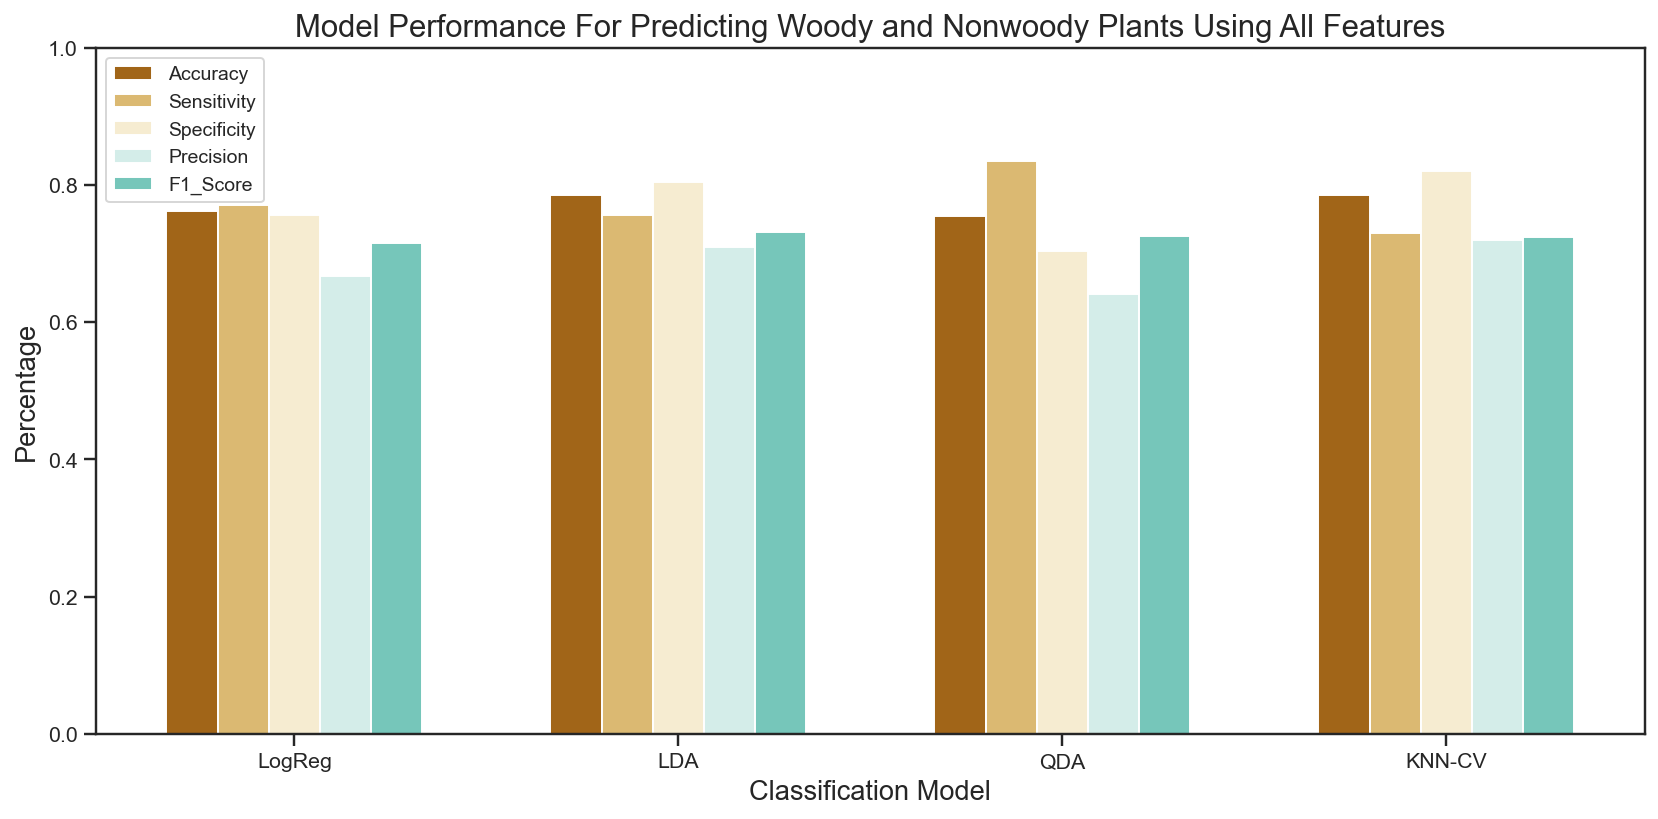

In [40]:
#Bar Graph
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
print(models)
accuracies = statallfeatures_dic["Accuracy"]
print("Accuracies" + str(accuracies))
sensitivities = statallfeatures_dic["Sensitivity"]
print("Sen" + str(sensitivities))
specificities = statallfeatures_dic["Specificity"]
print("Spec" + str(specificities))
precisions = statallfeatures_dic["Precision"]
print("P" + str(precisions))
f1_scores = statallfeatures_dic["F1_Score"]
print("F1" + str(f1_scores))

x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
import seaborn as sns
colors = sns.color_palette("BrBG")

acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color=colors[0])
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color=colors[1])
spe = ax.bar(x,specificities, width, label='Specificity', color=colors[2])
pre = ax.bar(x+width, precisions, width, label='Precision', color=colors[3])
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score', color=colors[4])

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Model Performance For Predicting Woody and Nonwoody Plants Using All Features', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set(ylim=(0.0, 1))


fig.tight_layout()

plt.legend(loc="upper left", prop={'size': 10})
plt.show()

fig.savefig('AllFeaturesPerformance.png')

#Code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

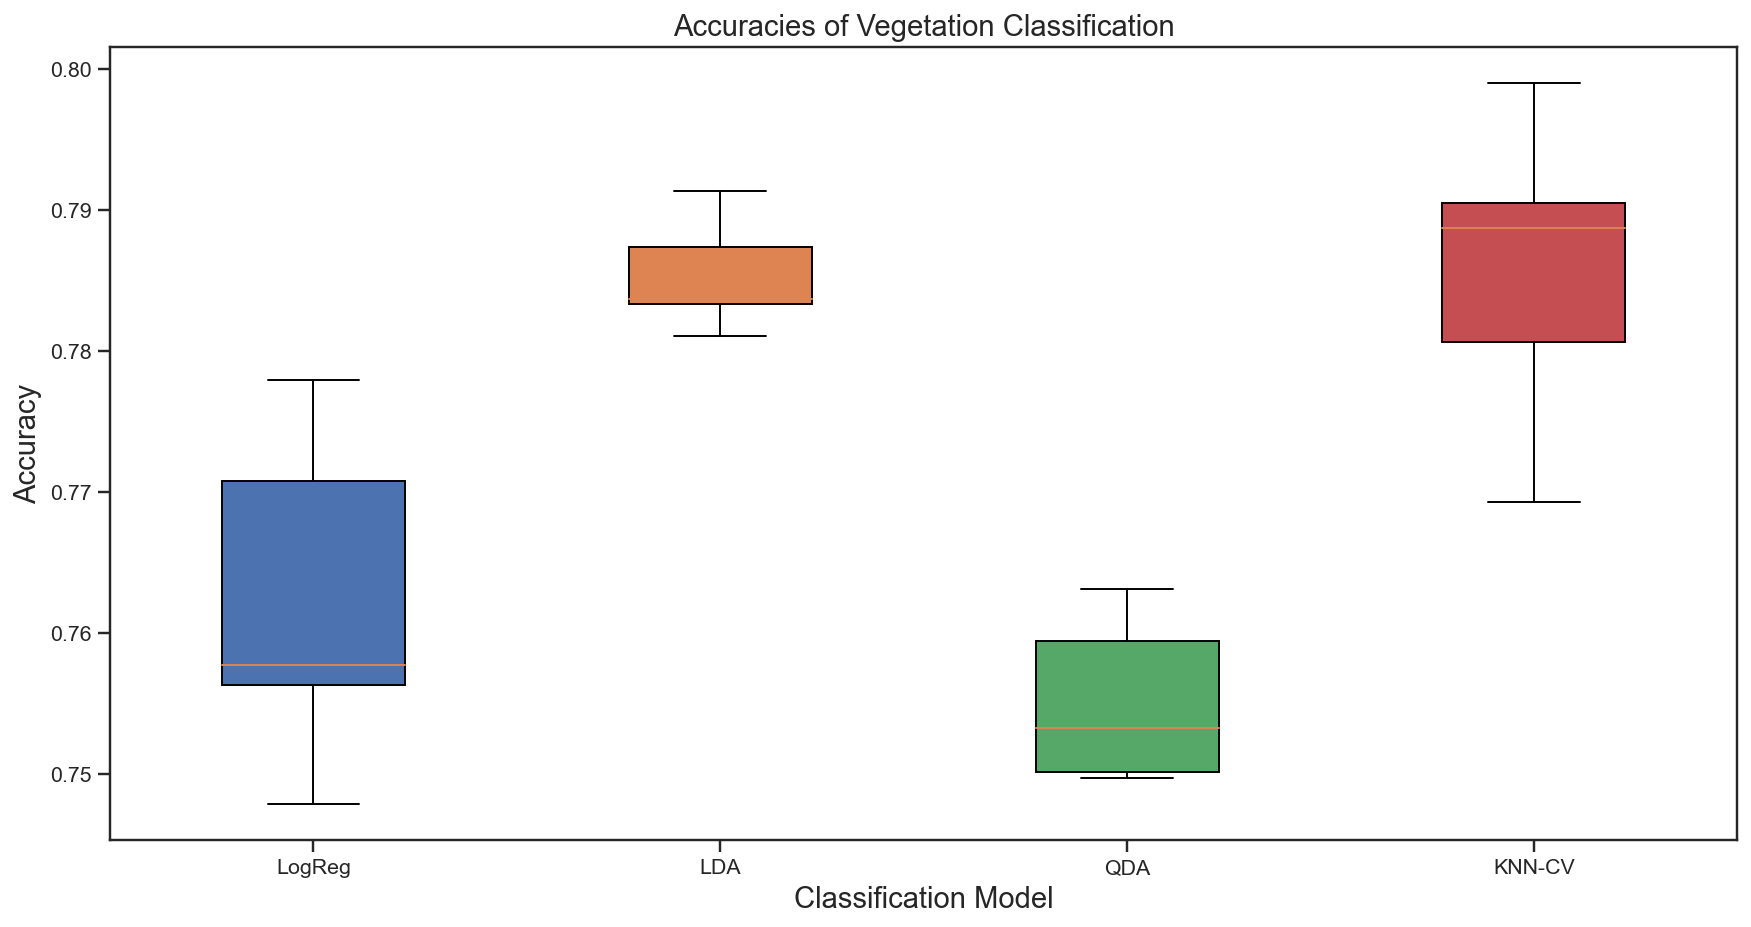

In [44]:
#Box Plot Accuracies

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs_dic['LogReg']
LDAAcc = indaccs_dic['LDA']
QDAAcc = indaccs_dic['QDA']
KNNAcc = indaccs_dic['KNN']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
bplot = ax.boxplot(data, patch_artist = True)

ax.set_title('Accuracies of Vegetation Classification', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

import seaborn as sns
#colors = sns.color_palette("colorblind")
colors = sns.color_palette()

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.show()

In [42]:
print("Log reg act: " + str(needed))
print("Log reg pred: " + str(tFWC4))
print("QDA act: " + str(needed2))
print("QDA pred: " + str(tFWC2))
print("LDA act: " + str(needed3))
print("LDA pred: " + str(tFWC))
print("KNN act: " + str(needed4))
print("KNN pred: " +str(tFWC3))

Log reg act: 44.88790406044506
Log reg pred: 55.23135943518059
QDA act: 44.88790406044506
QDA pred: 49.50647696930986
LDA act: 44.88790406044506
LDA pred: 58.7042639348234
KNN act: 44.88790406044506
KNN pred: 60.74115643961047


In [43]:
Logerrorrate = abs((needed-tFWC4)/needed) *100
QDAerrorrate = abs((needed-tFWC2)/needed) *100
LDAerrorrate = abs((needed-tFWC)/needed) *100
KNNerrorrate = abs((needed-tFWC3)/needed) *100

print("log ER = " + str(Logerrorrate))
print("QDA ER = " + str(QDAerrorrate))
print("LDA ER = " + str(LDAerrorrate))
print("KNN ER = " + str(KNNerrorrate))

log ER = 23.0428566252665
QDA ER = 10.289125780177953
LDA ER = 30.779694805472623
KNN ER = 35.31742617747929
